In [4]:
import cv2
import numpy as np
import os
from tqdm import tqdm

def extract_patches_from_folder(input_folder, output_folder, patch_size=512, overlap=0.2):
    """
    Cuts large images into smaller 'patches'.
    - patch_size: The height/width of each square crop (e.g., 512 px)
    - overlap: Percentage of overlap between patches (0.2 = 20%) to ensure we don't cut a crack in half.
    """
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
    files = [f for f in os.listdir(input_folder) if f.lower().endswith(valid_extensions)]
    
    print(f"Found {len(files)} large images. Starting patch extraction...")
    
    patch_count = 0
    stride = int(patch_size * (1 - overlap)) # How much we move the window each time
    
    for filename in tqdm(files):
        img_path = os.path.join(input_folder, filename)
        large_img = cv2.imread(img_path)
        
        if large_img is None: continue
        
        img_h, img_w, _ = large_img.shape
        
        # Loop over the image (Slide the window)
        for y in range(0, img_h - patch_size + 1, stride):
            for x in range(0, img_w - patch_size + 1, stride):
                
                # Cut out the patch
                patch = large_img[y:y+patch_size, x:x+patch_size]
                
                # --- FILTERING STEP ---
                # We don't want to save patches of just blue sky or plain concrete.
                # We check the "Standard Deviation" of the grayscale version.
                # High std_dev = lots of edges/texture (likely a crack or complex structure).
                # Low std_dev = smooth color (sky/flat wall).
                
                gray_patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
                std_dev = np.std(gray_patch)
                
                # Threshold: 20 is a safe bet. 
                # If std_dev < 20, it's probably just flat gray or blue sky. Skip it.
                if std_dev < 20:
                    continue
                
                # Save the valid patch
                save_name = f"{os.path.splitext(filename)[0]}_p{patch_count}.png"
                cv2.imwrite(os.path.join(output_folder, save_name), patch)
                patch_count += 1

    print(f"\nExtraction Complete.")
    print(f"Created {patch_count} patches in '{output_folder}'.")

# --- CONFIGURATION ---
raw_camera_folder = 'camera'     # Your original big photos
patches_output_dir = 'dataset_patches'      # New folder for the small squares

# Run Phase 0
# Create the raw folder if you haven't yet
if os.path.exists(raw_camera_folder):
    extract_patches_from_folder(raw_camera_folder, patches_output_dir)
else:
    print(f"Please create '{raw_camera_folder}' and put your camera images there.")

Found 368 large images. Starting patch extraction...


100%|██████████| 368/368 [04:33<00:00,  1.35it/s]


Extraction Complete.
Created 17793 patches in 'dataset_patches'.


In [5]:
import cv2
import numpy as np
import os
from tqdm import tqdm # Progress bar

def preprocess_and_save_batch(input_folder, output_folder, target_size=(512, 512)):
    # 1. Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Created output directory: {output_folder}")

    # Get list of valid image files
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(valid_extensions)]
    
    print(f"Found {len(image_files)} images in {input_folder}. Starting processing...")

    # 2. Process each image
    for filename in tqdm(image_files, desc="Processing Images"):
        img_path = os.path.join(input_folder, filename)
        
        try:
            # --- PREPROCESSING STEPS ---
            
            # Load Image
            img = cv2.imread(img_path)
            if img is None:
                continue

            # Convert to Grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Smart Resizing (Padding)
            h, w = gray.shape
            scale = min(target_size[0] / h, target_size[1] / w)
            new_w, new_h = int(w * scale), int(h * scale)
            resized = cv2.resize(gray, (new_w, new_h))

            # Create black canvas
            canvas = np.zeros(target_size, dtype=np.uint8)
            y_off = (target_size[0] - new_h) // 2
            x_off = (target_size[1] - new_w) // 2
            canvas[y_off:y_off+new_h, x_off:x_off+new_w] = resized

            # Denoise (Bilateral Filter)
            # Reduced sigmaColor and sigmaSpace from 75 to 30
            # Reduced diameter (d) from 9 to 5
            denoised = cv2.bilateralFilter(canvas, 5, 30, 30)

            # Contrast Enhancement (CLAHE)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            enhanced = clahe.apply(denoised)

            # --- SAVING STEPS ---
            
            # Note: We save as uint8 (0-255) so they are viewable image files.
            # Normalization (0-1) usually happens right before feeding into the model during training.
            
            # Save as PNG to prevent JPEG compression artifacts
            output_filename = os.path.splitext(filename)[0] + "_std.png"
            output_path = os.path.join(output_folder, output_filename)
            
            cv2.imwrite(output_path, enhanced)
            
        except Exception as e:
            print(f"Error processing {filename}: {e}")

    print(f"\nSuccess! Processed images saved to: {output_folder}")

# --- CONFIGURATION ---
# UPDATE THESE PATHS BEFORE RUNNING
input_dir = 'dataset_patches'   # Folder containing your original camera shots
output_dir = 'dataset_standardized' # Folder where clean images will be saved

# Run the function
# Only run this if the input directory actually exists
if os.path.exists(input_dir):
    preprocess_and_save_batch(input_dir, output_dir)
else:
    print(f"Please create the folder '{input_dir}' and put your images in it first.")

Created output directory: dataset_standardized
Found 17793 images in dataset_patches. Starting processing...


Processing Images: 100%|██████████| 17793/17793 [07:27<00:00, 39.73it/s]  


Success! Processed images saved to: dataset_standardized


In [6]:
import cv2
import numpy as np
import os
import shutil
from tqdm import tqdm

def auto_sort_cracks(input_folder, output_base, thresholds=(2.0, 5.0)):
    """
    Automatically sorts images based on calculated crack width.
    thresholds: (A, B)
      - Width < A pixels -> LIGHT
      - Width between A and B -> MEDIUM
      - Width > B pixels -> LARGE
    """
    
    # Create the class directories
    classes = ['light', 'medium', 'large']
    for c in classes:
        os.makedirs(os.path.join(output_base, c), exist_ok=True)
        
    # Get all images
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
    files = [f for f in os.listdir(input_folder) if f.lower().endswith(valid_extensions)]
    
    print(f"Auto-sorting {len(files)} images...")
    
    for filename in tqdm(files):
        img_path = os.path.join(input_folder, filename)
        
        # 1. Read the standardized (grayscale) image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        
        # 2. Extract the crack (Thresholding)
        # Since we ran CLAHE, cracks are dark. We invert so cracks are white.
        # You might need to adjust the '50' value if it picks up too much noise
        _, binary = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY_INV)
        
        # 3. Clean up noise (Morphology)
        # Removes tiny white dots that aren't cracks
        kernel = np.ones((3,3), np.uint8)
        opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        
        # 4. Measure Crack Width (Distance Transform)
        # This calculates the distance of every white pixel to the nearest black pixel.
        # The 'max' value represents half the width of the thickest part.
        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
        if dist_transform.max() == 0:
            max_width = 0
        else:
            # Multiply by 2 because distance transform gives radius (center to edge)
            max_width = dist_transform.max() * 2 
            
        # 5. Sort into folders
        if max_width < thresholds[0]:
            category = 'light'
        elif max_width < thresholds[1]:
            category = 'medium'
        else:
            category = 'large'
            
        # Move (or copy) the file
        # We copy 'img_path' (the standardized image) to the new folder
        shutil.copy(img_path, os.path.join(output_base, category, filename))

    print(f"Done! Check the '{output_base}' folder.")

# --- CONFIGURATION ---
# Use the folder where you saved the PREPROCESSED images (Phase 1 output)
std_images_dir = 'dataset_standardized' 
sorted_dataset_dir = 'dataset_train'

# Thresholds need tuning!
# Start with: < 4 pixels is Light, > 10 pixels is Large
# If everything goes to "Light", lower these numbers.
auto_sort_cracks(std_images_dir, sorted_dataset_dir, thresholds=(4.0, 10.0))

Auto-sorting 17793 images...


100%|██████████| 17793/17793 [04:11<00:00, 70.73it/s]

Done! Check the 'dataset_train' folder.


In [7]:
import os
import shutil
import random
from tqdm import tqdm

def split_dataset(input_folder, output_folder, split_ratios=(0.7, 0.2, 0.1)):
    """
    Splits a sorted dataset into Train, Validation, and Test sets.
    
    input_folder:  Path to folder containing 'light', 'medium', 'large'
    output_folder: Path where 'train', 'val', 'test' folders will be created
    split_ratios:  (Train%, Val%, Test%) - must sum to 1.0
    """
    
    if sum(split_ratios) != 1.0:
        print("Error: Split ratios must sum to 1.0 (e.g., 0.7 + 0.2 + 0.1)")
        return

    # Define the classes based on what's in the input folder
    classes = [d for d in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, d))]
    
    print(f"Found classes: {classes}")
    
    # Create the output directories
    for split in ['train', 'val', 'test']:
        for cls in classes:
            os.makedirs(os.path.join(output_folder, split, cls), exist_ok=True)
            
    # Process each class
    for cls in classes:
        cls_dir = os.path.join(input_folder, cls)
        images = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Shuffle randomly so the split isn't biased
        random.shuffle(images)
        
        # Calculate split indices
        n_total = len(images)
        n_train = int(n_total * split_ratios[0])
        n_val = int(n_total * split_ratios[1])
        # The rest goes to test
        
        train_imgs = images[:n_train]
        val_imgs = images[n_train:n_train + n_val]
        test_imgs = images[n_train + n_val:]
        
        print(f"Class '{cls}': {len(train_imgs)} Train, {len(val_imgs)} Val, {len(test_imgs)} Test")
        
        # Helper function to copy files
        def copy_files(file_list, destination_split):
            for filename in file_list:
                src = os.path.join(cls_dir, filename)
                dst = os.path.join(output_folder, destination_split, cls, filename)
                shutil.copy(src, dst)

        # Execute copies
        copy_files(train_imgs, 'train')
        copy_files(val_imgs, 'val')
        copy_files(test_imgs, 'test')

    print(f"\nSuccess! Dataset split created in: {output_folder}")

# --- CONFIGURATION ---
# The folder created by the Auto-Sorter (contains light/medium/large)
source_data_dir = 'dataset_train' 

# The NEW folder that will contain train/val/test
final_data_dir = 'dataset_final'

# Run the split
if os.path.exists(source_data_dir):
    split_dataset(source_data_dir, final_data_dir)
else:
    print(f"Could not find '{source_data_dir}'. Did you run the Auto-Sorter?")

Found classes: ['large', 'light', 'medium']
Class 'large': 10214 Train, 2918 Val, 1460 Test
Class 'light': 581 Train, 166 Val, 83 Test
Class 'medium': 1659 Train, 474 Val, 238 Test

Success! Dataset split created in: dataset_final


Using device: cuda
Classes found: ['large', 'light', 'medium']
Dataset sizes: {'train': 12454, 'val': 3558}


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\sreeh/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 10.0MB/s]


Epoch 1/20
----------
train Loss: 0.4584 Acc: 0.8196
val Loss: 0.4313 Acc: 0.8300
-> Best model saved!

Epoch 2/20
----------
train Loss: 0.4219 Acc: 0.8221
val Loss: 0.4152 Acc: 0.8356
-> Best model saved!

Epoch 3/20
----------
train Loss: 0.4128 Acc: 0.8235
val Loss: 0.4225 Acc: 0.8345

Epoch 4/20
----------
train Loss: 0.4140 Acc: 0.8263
val Loss: 0.3860 Acc: 0.8378
-> Best model saved!

Epoch 5/20
----------
train Loss: 0.4124 Acc: 0.8252
val Loss: 0.3803 Acc: 0.8384
-> Best model saved!

Epoch 6/20
----------
train Loss: 0.4030 Acc: 0.8290
val Loss: 0.3949 Acc: 0.8457
-> Best model saved!

Epoch 7/20
----------
train Loss: 0.4091 Acc: 0.8329
val Loss: 0.4142 Acc: 0.8361

Epoch 8/20
----------
train Loss: 0.4005 Acc: 0.8333
val Loss: 0.4432 Acc: 0.8406

Epoch 9/20
----------
train Loss: 0.3983 Acc: 0.8327
val Loss: 0.4095 Acc: 0.8356

Epoch 10/20
----------
train Loss: 0.4004 Acc: 0.8351
val Loss: 0.3742 Acc: 0.8471
-> Best model saved!

Epoch 11/20
----------
train Loss: 0.3961 A

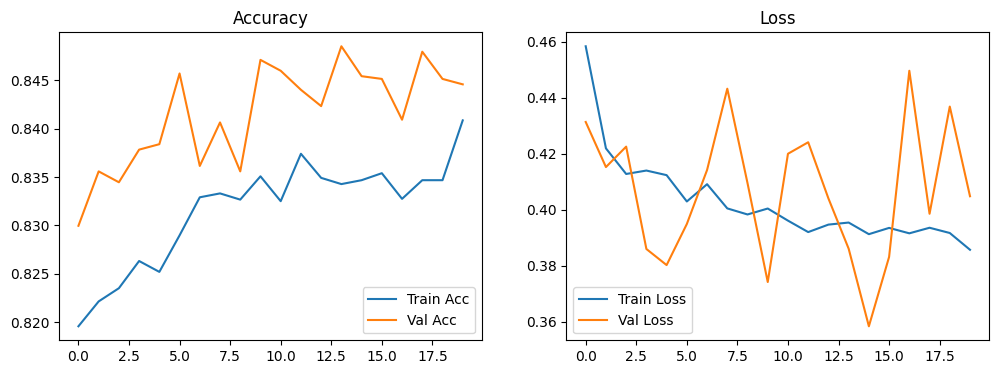

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
import time
import copy
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ---
DATA_DIR = 'dataset_final'  # Root folder with train/val/test
NUM_CLASSES = 3             # light, medium, large
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

# --- 2. DATA TRANSFORMS ---
# We must resize to 224x224 for MobileNetV2 and normalize to ImageNet stats
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        # Normalize with ImageNet mean/std (required for transfer learning)
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- 3. DATA LOADERS ---
def get_data_loaders(data_dir):
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                      for x in ['train', 'val']}
    
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
                   for x in ['train', 'val']}
    
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    
    return dataloaders, dataset_sizes, class_names

# Check if data exists before running
if not os.path.exists(os.path.join(DATA_DIR, 'train')):
    raise FileNotFoundError(f"Could not find {DATA_DIR}/train. Did you run the split script?")

dataloaders, dataset_sizes, class_names = get_data_loaders(DATA_DIR)
print(f"Classes found: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")

# --- 4. MODEL SETUP (MobileNetV2) ---
def build_model(num_classes):
    # Load pre-trained MobileNetV2
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    
    # Freeze the feature extraction layers (we don't want to retrain them yet)
    for param in model.features.parameters():
        param.requires_grad = False
        
    # Replace the final classifier head
    # MobileNetV2 classifier is: Dropout -> Linear
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(num_ftrs, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, num_classes) # Output layer (3 classes)
    )
    
    return model.to(DEVICE)

model = build_model(NUM_CLASSES)

# --- 5. OPTIMIZER & LOSS ---
criterion = nn.CrossEntropyLoss()
# Only optimize parameters that require gradients (the classifier head)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

# --- 6. TRAINING FUNCTION ---
def train_model(model, criterion, optimizer, num_epochs=20):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # Deep copy the model if it's the best one so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_bridge_model.pth')
                print("-> Best model saved!")

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# --- 7. RUN TRAINING ---
trained_model, history = train_model(model, criterion, optimizer, num_epochs=EPOCHS)

# --- 8. PLOT RESULTS ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

Loading model from best_bridge_model.pth...
Running predictions on Test Set...

TEST SET RESULTS
              precision    recall  f1-score   support

       large       0.85      0.99      0.92      1460
       light       0.70      0.08      0.15        83
      medium       0.62      0.21      0.31       238

    accuracy                           0.84      1781
   macro avg       0.73      0.43      0.46      1781
weighted avg       0.82      0.84      0.80      1781



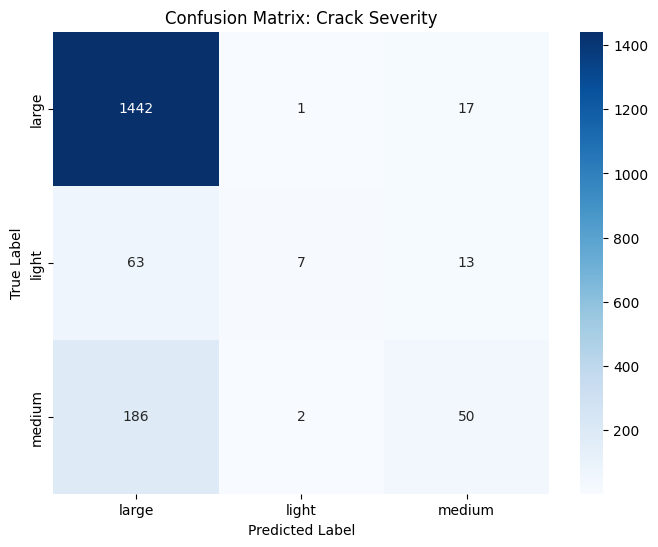

In [9]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

# --- CONFIGURATION ---
DATA_DIR = 'dataset_final'
TEST_DIR = os.path.join(DATA_DIR, 'test')
MODEL_PATH = 'best_bridge_model.pth' # The file saved during training
NUM_CLASSES = 3
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. REBUILD MODEL ARCHITECTURE ---
# We must define the exact same architecture to load the weights
def build_model(num_classes):
    model = models.mobilenet_v2(weights=None) # No need to download ImageNet weights again
    
    # Re-create the classifier head exactly as we did in training
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(num_ftrs, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, num_classes)
    )
    return model

# --- 2. LOAD DATA ---
# Use the same transforms as Validation (Resize + Normalize only)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

if os.path.exists(TEST_DIR):
    test_dataset = datasets.ImageFolder(TEST_DIR, test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    class_names = test_dataset.classes # ['large', 'light', 'medium']
else:
    print(f"Error: {TEST_DIR} not found.")
    exit()

# --- 3. RUN PREDICTIONS ---
def evaluate_model():
    print(f"Loading model from {MODEL_PATH}...")
    model = build_model(NUM_CLASSES)
    
    # Load the trained weights
    # map_location ensures it loads on CPU if you trained on GPU but are now on CPU
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval() # Set to evaluation mode (turns off Dropout)

    all_preds = []
    all_labels = []

    print("Running predictions on Test Set...")
    with torch.no_grad(): # Disable gradient calculation for speed
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = evaluate_model()

# --- 4. GENERATE METRICS ---
print("\n" + "="*30)
print("TEST SET RESULTS")
print("="*30)

# Classification Report (Precision, Recall, F1-Score)
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# --- 5. PLOT CONFUSION MATRIX ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Crack Severity')
plt.show()